### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 9th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.
```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```
This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

### Solution

In [1]:
import numpy as np
from matplotlib import pyplot as plt

### (1)

In [2]:
# 1)

# Read in SDSS galaxy color data
data = np.load("../../homeworks/hw_data/hw8_data_1.npy")

# print all of the column names
print('column names: ',data.dtype)

# create arrays of (𝑢−𝑔), (𝑔−𝑟), (𝑟−𝑖), and (𝑖−𝑧) colors
u_g = data['u']-data['g']
g_r = data['g']-data['r']
r_i = data['r']-data['i']
i_z = data['i']-data['z']
# create arrays of redshift and the spectral class
redshift = data['redshift']
spec_class = data['specClass']

# How many regular galaxies and how many quasars are in this sample?
print('\nnumber of quasars = ',len(np.where(spec_class=='QSO')[0]))
print('number of galaxies = ',len(np.where(spec_class=='GALAXY')[0]))

column names:  [('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('specClass', '<U6'), ('redshift', '<f8'), ('redshift_err', '<f8')]

number of quasars =  7192
number of galaxies =  42808


### (2)

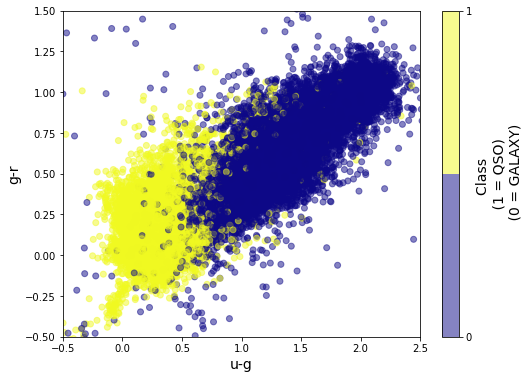

In [3]:
# 2)

# Define labels for color coding galaxy & quasar class
labels = np.full(len(spec_class), 0)
idx1, idx2 = np.where(spec_class=='QSO')[0], np.where(spec_class=='GALAXY')[0]
labels[idx1] = 1
labels[idx2] = 0

# Make a scatter plot of (𝑢−𝑔) versus (𝑔−𝑟)
fig, ax = plt.subplots(figsize=(8,6))

im = ax.scatter(u_g,g_r, c=labels, cmap=plt.cm.get_cmap('plasma', 2), alpha=0.5)
ax.set_xlabel('u-g',fontsize=14); ax.set_ylabel('g-r',fontsize=14)
ax.set_xlim(-0.5,2.5); ax.set_ylim(-0.5,1.5)
cbar = fig.colorbar(im,ticks=[0, 1])
cbar.set_label('Class \n (1 = QSO) \n (0 = GALAXY)', rotation=90, fontsize=14) 
plt.show()

### (3)

In [4]:
# 3) Stack all colors and the redshift into a data matrix, 𝑋. Create a target label array that has  0  for a 
# regular galaxy and  1  for a quasar. Perform a train-test split, taking  20%  of the data for testing.

from sklearn.model_selection import train_test_split

# Stack all colors and the redshift into a data matrix
X = np.array([u_g, g_r, r_i, i_z, redshift]).T
np.shape(X)

# label array was created in problem (2). Define that as 'y' here.
y = labels

# perform a train-test split, taking  20%  of the data for testing
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=20/100)

### (4)

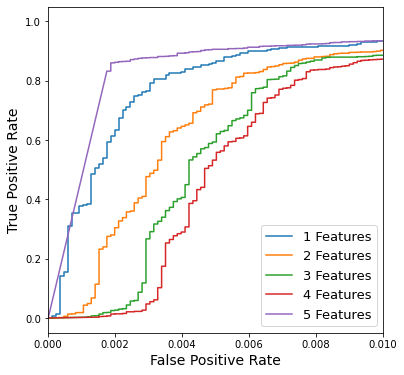

In [5]:
# 4)
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve

# Create a compact for loop that iterates over the fitting of a Gaussian Naive Bayes classification 
# algorithm to successively more features of the data.
fprs,tprs = [],[]
for i in range(np.shape(X)[1]):
    gnb = GaussianNB()
    gnb.fit(Xtrain[0:len(Xtrain),:i+1],ytrain)
    y_prob = gnb.predict_proba(Xtest[0:len(Xtrain),:i+1])
#   compute an ROC curve; access the relevant quasar probability using 'gnb.classes', which is '1' for quasar
    fpr, tpr, thresh = roc_curve(ytest, y_prob[:,1])
#   append false positive and true positive rates
    fprs.append(fpr)
    tprs.append(tpr)

# make plot showing ROC curves for GNB classification with more and more features of the data
fig, ax = plt.subplots(figsize=(6,6))
for j in range(len(fprs)):
    ax.plot(fprs[j], tprs[j], label=str(j+1)+' Features')
    ax.set_xlim(0,0.01)
ax.set_xlabel('False Positive Rate',fontsize=14); plt.ylabel('True Positive Rate',fontsize=14)
plt.legend(fontsize=13)
plt.show()

It looks like feature 5 (redshift) makes the classification easy. Including the 5th feature in the GNB fitting maximizes the area under the ROC curve.

### (5)

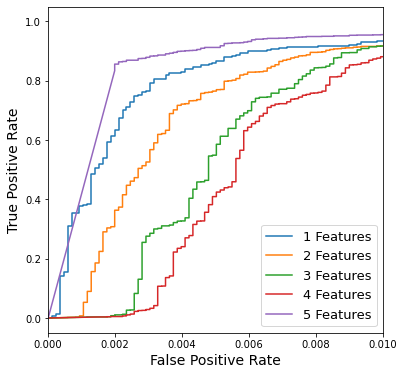

In [6]:
# 5) 

# Repeat (4) for Quadratic Discriminant Analysis.

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

fprs,tprs = [],[]
for i in range(np.shape(X)[1]):
    qda = QDA()
    qda.fit(Xtrain[0:len(Xtrain),:i+1],ytrain)
    y_prob = qda.predict_proba(Xtest[0:len(Xtrain),:i+1])
    fpr, tpr, thresh = roc_curve(ytest, y_prob[:,1])
    fprs.append(fpr)
    tprs.append(tpr)

# plot the ROC curves
fig, ax = plt.subplots(figsize=(6,6))
for j in range(len(fprs)):
    ax.plot(fprs[j], tprs[j], label=str(j+1)+' Features')
    ax.set_xlim(0,0.01)
ax.set_xlabel('False Positive Rate',fontsize=14); plt.ylabel('True Positive Rate',fontsize=14)
plt.legend(fontsize=13)
plt.show()

Just like in the previous problem, including the 5th feature makes the QDA classification easier.

### (6)

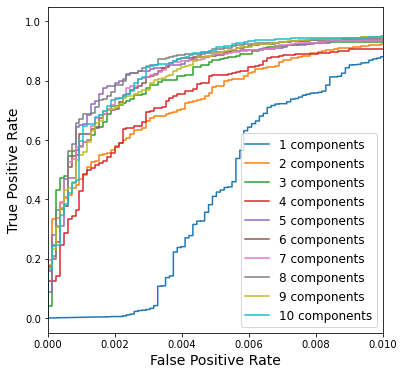

In [7]:
# 6) 

# Try classification with GMM Bayes. 
# Restrict the training and testing to be just on the 4 colors. 
# Iterate now over number of components in the GMM Bayes fit up to  10

from astroML.classification import GMMBayes
from sklearn.metrics import roc_auc_score

fprs,tprs = [],[]
area = []
for i in range(10):
    gmmb = GMMBayes(i+1) # i+1 clusters/components per class
    gmmb.fit(Xtrain[0:len(Xtrain),:4],ytrain)
    y_prob = gmmb.predict_proba(Xtest[0:len(Xtrain),:4])
    fpr, tpr, thresh = roc_curve(ytest, y_prob[:,1])
#   compute the area under the ROC curves using 'roc_auc_score'.
#   note to self: 'roc_auc_score' gives the same thing as using the trapezoidal rule to calculate the area 
#   under a curve –– can use 'np.trapz(tpr,fpr)', and it gives the exact same thing).
    area.append(roc_auc_score(ytest, y_prob[:,1]))
    fprs.append(fpr)
    tprs.append(tpr)
    
# plot ROC curves
fig, ax = plt.subplots(figsize=(6,6))
for j in range(len(fprs)):
    ax.plot(fprs[j], tprs[j], label=str(j+1)+' components')
    ax.set_xlim(0,0.01)
ax.set_xlabel('False Positive Rate',fontsize=14); plt.ylabel('True Positive Rate',fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [8]:
# Find the number of components that gives the best performance.

# It's difficult to visually discern which component number is best. 
# So calculate the areas under the ROC curves to find which number of components maximizes the area.
# Area was computed using 'roc_auc_score'.

max_area_idx = np.where(area==np.amax(area))[0][0]
best_component = np.arange(1,11,1)[max_area_idx]
print(str(best_component),'components gives the best performance.')

10 components gives the best performance.


Looking at the plot, I do think 9 or 10 components is a believable result.

### (7)

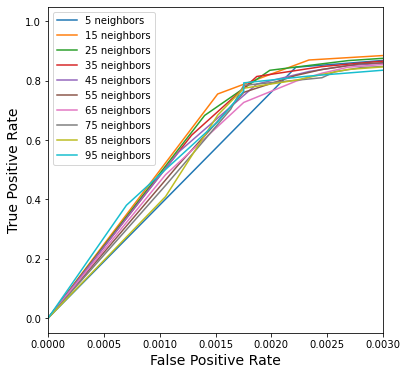

In [9]:
# 7) 

# Repeat (6) for 𝐾 -nearest neighbor classification, looping over number of 
# neighbors between 5 and 100 in steps of 10.

from sklearn.neighbors import KNeighborsClassifier

fprs,tprs = [],[]
area = []
n = np.arange(5,101,10)
for i in n:
    knc = KNeighborsClassifier(i) # i number of neighbors
    knc.fit(Xtrain[0:len(Xtrain),:4],ytrain)
    y_prob = knc.predict_proba(Xtest[0:len(Xtrain),:4])
    fpr, tpr, thresh = roc_curve(ytest, y_prob[:,1])
#   calculate area
    area.append(roc_auc_score(ytest, y_prob[:,1]))
    fprs.append(fpr)
    tprs.append(tpr)
    
# plot ROC curves
fig, ax = plt.subplots(figsize=(6,6))
for j in range(len(fprs)):
    ax.plot(fprs[j], tprs[j], label=str(n[j])+' neighbors')
    ax.set_xlim(0,0.003)
ax.set_xlabel('False Positive Rate',fontsize=14); plt.ylabel('True Positive Rate',fontsize=14)
plt.legend()
plt.show()

In [10]:
# Find the number that gives the best performance.

# again, it's very difficult to tell from the plot, so find area under each ROC curve
max_area_idx = np.where(area==np.amax(area))[0][0]
best_component = n[max_area_idx]
print(str(best_component),'neighbors gives the best performance.')

95 neighbors gives the best performance.


Again, looking at the ROC plot, I do think 95 neighbors is a believable result.

### (8)

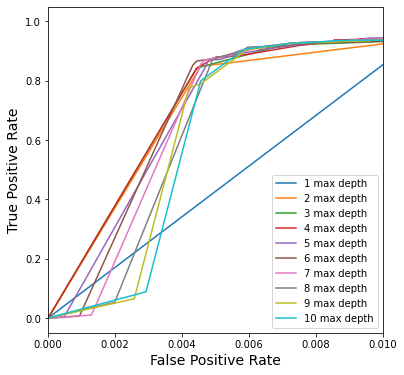

In [11]:
# 8) 

# Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10.

from sklearn.tree import DecisionTreeClassifier

fprs,tprs = [],[]
area = []
for i in range(10):
    dtree = DecisionTreeClassifier(max_depth=i+1) 
    dtree.fit(Xtrain[0:len(Xtrain),:4],ytrain)
    y_prob = dtree.predict_proba(Xtest[0:len(Xtrain),:4])
    fpr, tpr, thresh = roc_curve(ytest, y_prob[:,1])
    area.append(roc_auc_score(ytest, y_prob[:,1]))
    fprs.append(fpr)
    tprs.append(tpr)
    
fig, ax = plt.subplots(figsize=(6,6))
for j in range(len(fprs)):
    ax.plot(fprs[j], tprs[j], label=str(j+1)+' max depth')
    ax.set_xlim(0,0.01)
ax.set_xlabel('False Positive Rate',fontsize=14); plt.ylabel('True Positive Rate',fontsize=14)
plt.legend()
plt.show()

In [12]:
# Find the number that gives the best performance.

max_area_idx = np.where(area==np.amax(area))[0][0]
best_component = np.arange(1,11,1)[max_area_idx]
print(str(best_component),'max tree depth gives the best performance.')

5 max tree depth gives the best performance.


### (9)

In [13]:
# 9)

# Plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, 
# all using just the 4 colors.

gnb = GaussianNB()
gnb.fit(Xtrain[0:len(Xtrain),:4],ytrain)
y_prob_gnb = gnb.predict_proba(Xtest[0:len(Xtrain),:4])
gnb_fpr, gnb_tpr, gnb_thresh = roc_curve(ytest, y_prob_gnb[:,1])

qda = QDA()
qda.fit(Xtrain[0:len(Xtrain),:4],ytrain)
y_prob_qda = qda.predict_proba(Xtest[0:len(Xtrain),:4])
qda_fpr, qda_tpr, qda_thresh = roc_curve(ytest, y_prob_qda[:,1])

gmmb = GMMBayes(10) # 10 clusters = best-performing GMMBayes ???????????? ???????
gmmb.fit(Xtrain[0:len(Xtrain),:4],ytrain)
y_prob_gmmb = gmmb.predict_proba(Xtest[0:len(Xtrain),:4])
gmmb_fpr, gmmb_tpr, gmmb_thresh = roc_curve(ytest, y_prob_gmmb[:,1])

knc = KNeighborsClassifier(95) #"""95: THIS IS PROBABLY WRONG"""
knc.fit(Xtrain[0:len(Xtrain),:4],ytrain)
y_prob_knc = knc.predict_proba(Xtest[0:len(Xtrain),:4])
knc_fpr, knc_tpr, knc_thresh = roc_curve(ytest, y_prob_knc[:,1])

dtree = DecisionTreeClassifier(max_depth=5) 
dtree.fit(Xtrain[0:len(Xtrain),:4],ytrain)
y_prob_dtree = dtree.predict_proba(Xtest[0:len(Xtrain),:4])
dtree_fpr, dtree_tpr, dtree_thresh = roc_curve(ytest, y_prob_dtree[:,1])

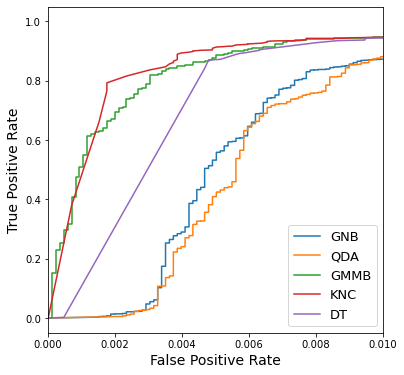

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(gnb_fpr, gnb_tpr,label='GNB')
ax.plot(qda_fpr, qda_tpr,label='QDA')
ax.plot(gmmb_fpr, gmmb_tpr,label='GMMB')
ax.plot(knc_fpr, knc_tpr,label='KNC')
ax.plot(dtree_fpr, dtree_tpr,label='DT')
ax.set_xlim(0,0.01)
ax.set_xlabel('False Positive Rate',fontsize=14); ax.set_ylabel('True Positive Rate',fontsize=14)
plt.legend(fontsize=13)
plt.show()

In [18]:
# What is the overall best-performing classifier?

# compute the area under the ROC curves

classifier_area = np.array([roc_auc_score(ytest, y_prob_gnb[:,1]),roc_auc_score(ytest, y_prob_qda[:,1]),
                           roc_auc_score(ytest, y_prob_gmmb[:,1]),roc_auc_score(ytest, y_prob_knc[:,1]),
                           roc_auc_score(ytest, y_prob_dtree[:,1])])
max_area_idx = np.where(classifier_area==np.amax(classifier_area))[0][0]
# best_classifier = np.arange(1,11,1)[max_area_idx]

best_classifier = np.array(['GNB','QDA','GMMB','KNC','DT'])[max_area_idx]

print(str(best_classifier),'is the best-performing classifier.')
print('Note: from the plot, it looks like both KNC and GMMB do a pretty good job, but in this case, KNC is best.')

KNC is the best-performing classifier.
Note: from the plot, it looks like both KNC and GMMB do a pretty good job, but in this case, KNC is best.


### (10)

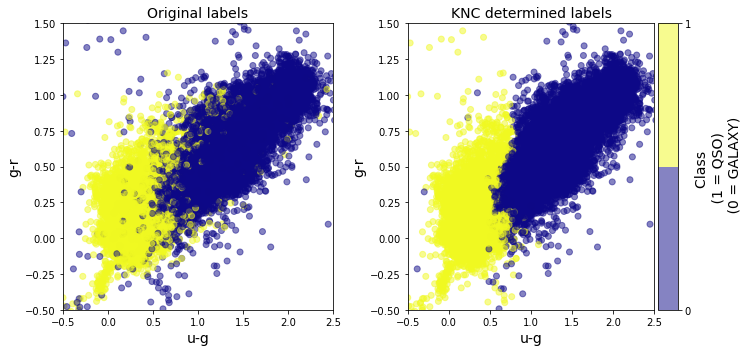

In [19]:
# 10) 

# Make a 2-panel plot, showing in the left panel the color-coded training data in (𝑢−𝑔) versus (𝑔−𝑟)  
# (similar to item 2 above), and in the right panel the same features of the testing data color coded by their 
# predicted class from the tuned best-performing classifier.

from mpl_toolkits.axes_grid1 import make_axes_locatable

knc_pred = knc.predict(X[0:len(X),:4])

fig,ax = plt.subplots(1, 2, figsize=(10.5, 5))
im1 = ax[0].scatter(u_g,g_r, c=labels, cmap=plt.cm.get_cmap('plasma', 2), alpha=0.5)
ax[0].set_xlabel('u-g',fontsize=14); ax[0].set_ylabel('g-r',fontsize=14)
ax[0].set_xlim(-0.5,2.5); ax[0].set_ylim(-0.5,1.5)
ax[0].set_title('Original labels',fontsize=14)

im2 = ax[1].scatter(u_g,g_r, c=knc_pred, cmap=plt.cm.get_cmap('plasma', 2), alpha=0.5)
ax[1].set_xlabel('u-g',fontsize=14); ax[1].set_ylabel('g-r',fontsize=14)
ax[1].set_xlim(-0.5,2.5); ax[1].set_ylim(-0.5,1.5)
ax[1].set_title('KNC determined labels',fontsize=14)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='8%', pad=0.05)
cbar = fig.colorbar(im2, cax=cax, ticks=[0, 1])

cbar.set_label('Class \n (1 = QSO) \n (0 = GALAXY)', rotation=90, fontsize=14)

plt.tight_layout()
plt.show()